6/17/2022 - v4 of code

Using the code to simulate YbOH levels relevant for Zeeman-Sisyphus transitions. 

This notebook is being updated to work with the `Eigenstate` struct that holds information about eigensystems.

In [1]:
using Revise

In [3]:
using MKL
using JuliaSpectra
using BenchmarkTools
using Parameters
using Plots
gr()
using LinearAlgebra
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libmkl_rt.1.dylib

In [3]:
const sol = 299792458
const h = 6.626e-34
const ħ = h / 2π
const μB = 4.66989733e-5 # in cm^-1/Gauss.
;

In [4]:
molecule = "YbOH"

@unpack B, γ, bF, c = MolParams[molecule]["X"]
const BX = B
const γX = γ
const bFX = bF
const cX = c

@unpack B, aSO, p2q, T0, gS, gL, gl′ = MolParams[molecule]["A"]
const BA = B
const ASO = aSO
const p2qA = p2q
const T0_A = T0
const gSX = gS
const gLA = gL
const gl′A = gl′
;

In [5]:
bounds_X = (J = 1/2:7/2, I=1/2, Σ=[-1/2,1/2], Λ=0, Ω=[1/2,-1/2], S = 1/2, F=0:4, M=-4:4)
basisX = enumerate_states(LinearCaseA_Field, bounds_X)
bounds_X_b = (J = 1/2:7/2, I=1/2, N=0:3, Λ=0, S = 1/2, F=0:4, M=-4:4)
basisX_b = enumerate_states(LinearCaseB_Field, bounds_X_b)

bounds_A = (J = 1/2:3/2, I=1/2, Σ=[-1/2,1/2], Λ=[-1,1], Ω=[1/2,-1/2],S = 1/2, F=0:2,M=-2:2)
basisA = enumerate_states(LinearCaseA_Field, bounds_A)
;

In [6]:
Bz = 0.0001

# Build ground state
Hrot = BX * Rotation
Hsr = γX * SpinRotation
Hhf = (bFX+0*cX/3) * Hyperfine_IS + cX/3 * Hyperfine_Dipolar
HX_op = Hrot+Hsr+Hhf+ Bz*μB*gSX*Zeeman
HX = Hamiltonian(basis=basisX_b, H_operator = HX_op)
build(HX)

# Build the excited state
Ho = T0_A * Origin
Hrot = BA * Rotation
HSO = ASO * SpinOrbit
Hld = p2qA * ΛDoubling_p2q
Hhf = -bFX/10 * HyperfineIL - bFX/4.5 * HyperfineIS
HA_op = Ho+Hrot+HSO+Hld+Hhf-Bz*μB*gSX*Zeeman_S - Bz*μB*gl′A*Zeeman_parity - Bz*μB*gLA*Zeeman_L
HA = Hamiltonian(basis=basisA, H_operator = HA_op)
build(HA)
;

Here are some functions to build the TDM operators between our basis states, to build the operator that converts the ground state from Hund's case (b) to case (a), and then functions to compute the branching ratios and transition intensities among the eigenstates.

In [7]:
# TDM matrix
TDMDict = Dict{Int64,Array{Float64}}()
for p = -1:1
    Tmat = zeros(length(basisX), length(basisA))
    for (i,state) in enumerate(basisX)
        for (j,state′) in enumerate(basisA)
            Tmat[i,j] = TDM_E1(state,state′,p)
        end
    end
    TDMDict[p] = Tmat
end

Scan over a range of B-fields and compute the eigenvalues and eigenvectors. Use the eigenshuffle method to keep the ordering matched to the zero-field eigenstate ordering.

This time, we use `pack_eigensystem=true` to use the new Eigenstate objects rather than the raw eigenvectors/eigenvalues being output in arrays.

In [8]:
Blist = range(0.001, stop=25000, length=1250)

# X State
Hrot = BX * Rotation
Hsr = γX * SpinRotation
Hhf = bFX * Hyperfine_IS + cX/3 * Hyperfine_Dipolar
HX0 = Hrot + Hsr + Hhf
eigsysX = eigenshuffle(HX0, μB*gS*Zeeman, basisX_b, Blist, pack_eigensystem=true)

# A State
Ho = T0_A * Origin
Hrot = BA * Rotation
HSO = ASO * SpinOrbit
Hld = p2qA * ΛDoubling_p2q
Hhf = -bFX/10 * HyperfineIL - bFX/4.5 * HyperfineIS
HA0 = Ho+Hrot+HSO+Hld+Hhf
HA1 = +μB*gS*Zeeman_S +μB*gl′*Zeeman_parity + μB*gL*Zeeman_L
eigsysA = eigenshuffle(HA0, HA1, basisA, Blist, pack_eigensystem=true)
;

Plot out the ground and excited state eigenvalues vs. B-field and highlight the states of interest for Zeeman-Sisyphus slowing.

In [9]:
# Set a conditions function that pulls out states according to their J or N values and whether they are WFS or SFS. 
function conditionsX_WFSSFS(eigsys)
    evecs = flatten(eigsys.coeffs) # pick out B=0 values
    basis = eigsys[1].basis # pick out B=0 values
    evals = eigsys.E
    zlab = "none"
    if evals[200] > evals[1]
        zlab = "WFS"
    elseif evals[200] < evals[1]
        zlab = "SFS"
    end
    Nlab = basis[argmax(abs2.(evecs[:,1]))].N
    return (Nlab, zlab)
end

function conditionsA_WFSSFS(eigsys)
    evecs = flatten(eigsys.coeffs) # pick out B=0 values
    basis = eigsys[1].basis # pick out B=0 values
    evals = eigsys.E
    zlab = "none"
    if evals[200] > evals[1]
        zlab = "WFS"
    elseif evals[200] < evals[1]
        zlab = "SFS"
    end
    parityop = build(Hamiltonian(basis=basis, H_operator = parity))
    plab = Int64(round(evecs[:,1]' * parityop * evecs[:,1], digits=1))
    Jlab = basis[argmax(abs2.(evecs[:,1]))].J
    return (Jlab, plab, zlab)
end
;
XindsDict = subspaceinds(eigsysX, conditionsX_WFSSFS)
AindsDict = subspaceinds(eigsysA, conditionsA_WFSSFS)
;

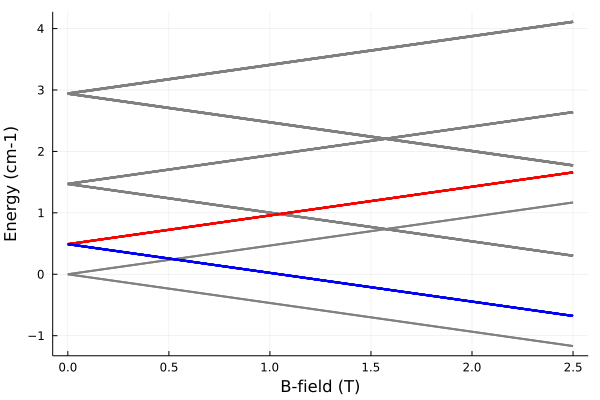

In [10]:
plot(Blist/1e4, eigsysX.E', color=:gray, legend=false, lw=2)
plot!(Blist/1e4, eigsysX[XindsDict[1,"WFS"],:].E', color=:red, legend=false, lw=2)
plot!(Blist/1e4, eigsysX[XindsDict[1,"SFS"],:].E', color=:blue, legend=false, lw=2)
xlabel!("B-field (T)")
ylabel!("Energy (cm-1)")

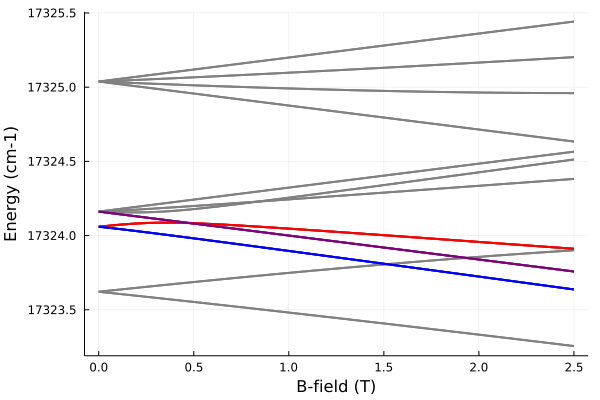

In [11]:
plot(Blist/1e4, eigsysA.E', color=:gray, legend=false, lw=2)
plot!(Blist/1e4, eigsysA[AindsDict[1/2,+1,"WFS"],:].E', color=:red, legend=false, lw=2)
plot!(Blist/1e4, eigsysA[AindsDict[1/2,+1,"SFS"],:].E', color=:blue, legend=false, lw=2)
plot!(Blist/1e4, eigsysA[AindsDict[3/2,+1,"SFS"],:].E', color=:purple, legend=false, lw=2)
xlabel!("B-field (T)")
ylabel!("Energy (cm-1)")

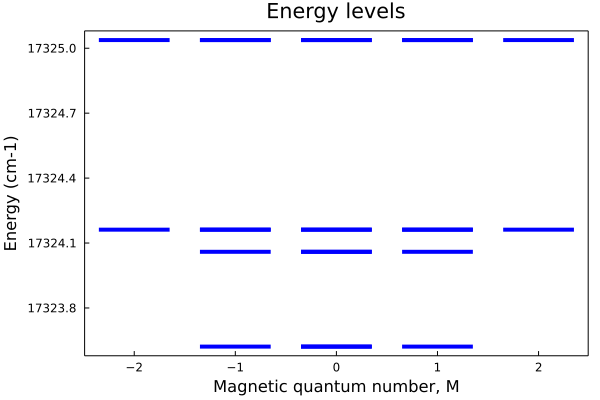

In [12]:
plotZeemanlevels(eigsysA[:,1],units="cm-1", title="Energy levels", lw=4, color=:blue, legend=false)

At a particular B-field, make a 2D map of the branching ratios and transition intensities among all states in our system. 

First, we need to express all eigensystems in the same basis.

In [13]:
eigsysX_a = changebasis(eigsysX, basisX)
eigsysX_a[1].basis
;

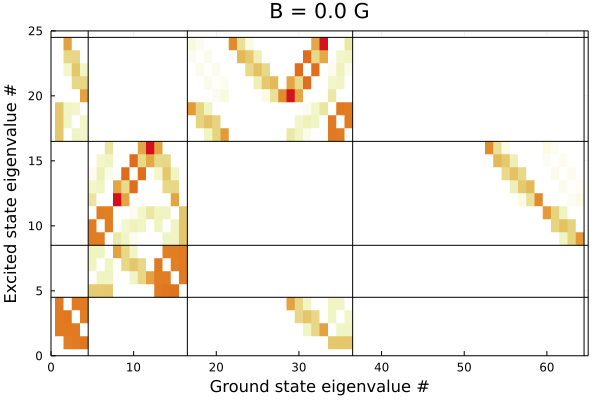

In [14]:
bv = 1
output = branchingratios(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict)
outputchop = round.(output,digits=4)
plottransitiontable(outputchop, basisX_b, basisA; title = "B = $(round(Blist[bv],digits=2)) G")

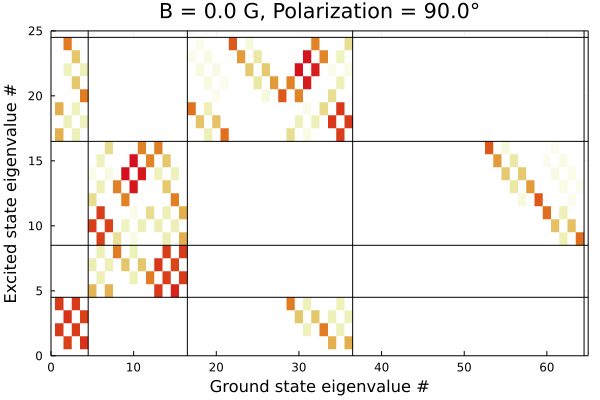

In [15]:
bv = 1
pol = pi/2
output = transitionintensities(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict, pol)
outputchop = round.(output,digits=4)
plottransitiontable(outputchop, basisX_b, basisA; title = "B = $(round(Blist[bv],digits=2)) G, Polarization = $(round(pol*180/pi,digits=1))°")

Check branching ratios from J'=3/2 to N"=1 and N"=3. Use the subspaceinds commmand to figure out which indices are which.

In [16]:
# Set a conditions function that pulls out states according to their J or N values.
function conditionsX(eigsys)
    basis = eigsys[1].basis
    evecs = eigsys[1].coeffs
    Nlab = basis[argmax(abs2.(evecs))].N
    Jlab = basis[argmax(abs2.(evecs))].J
    return (Nlab,Jlab)
end

function conditionsA(eigsys)
    basis = eigsys[1].basis
    evecs = eigsys[1].coeffs
    parityop = build(Hamiltonian(basis=basisA, H_operator = parity))
    plab = Int64(round(evecs' * parityop * evecs, digits=1))
    Jlab = basis[argmax(abs2.(evecs))].J
    return (Jlab, plab)
end

XindsDict = subspaceinds(eigsysX, conditionsX)
AindsDict = subspaceinds(eigsysA, conditionsA)

# # Pull out indices we'll use below.
XN1J05 = XindsDict[1,1/2]
XN1J15 = XindsDict[1,3/2]
XN1 = reduce(vcat,[XindsDict[1,i] for i in [1/2,3/2]])
XN3 = reduce(vcat,[XindsDict[3,i] for i in [5/2,7/2]])
ApJ15 = AindsDict[3/2,+1]
ApJ05 = AindsDict[1/2,+1]
;

In [17]:
# Expect about 30% to N"=3 and about 70% to N"1 (roughly 54% to J"=3/2 and 16% to J"=1/2.)
bv=1
BRs=branchingratios(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict)
println( round.( sum(BRs[XN1J15,ApJ15])/sum(BRs[:,ApJ15]), digits = 4 ) )
println( round.( sum(BRs[XN1J05,ApJ15])/sum(BRs[:,ApJ15]), digits = 4 ) )
println( round.( sum(BRs[XN3,ApJ15])/sum(BRs[:,ApJ15]), digits = 4 ) )

0.5333
0.1667
0.3


Now plot branching ratios as a function of B-field for the relevant excited states (J'=1/2 and J'=3/2, + parity).

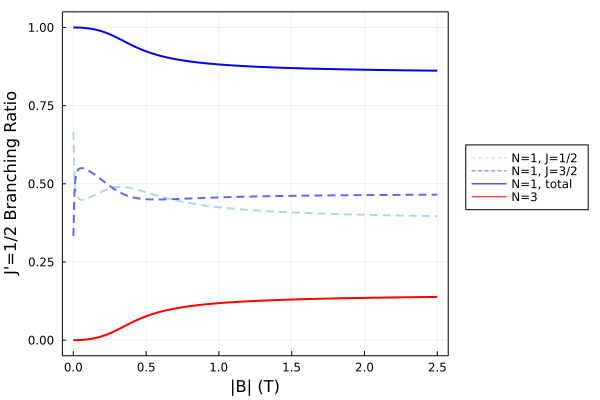

In [18]:
# PLot branching ratios from the J'=1/2 state
outlist_N3 = [] # branching to N=3
outlist_N1 = [] # branching to N=1
outlist_N1J05 = [] # branching to N=1, J=1/2 component
outlist_N1J15 = [] # branching to N=1, J=3/2 component

for bv in 1:length(Blist)
    BRs=branchingratios(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict)
    totalBR = sum(BRs[:,ApJ05])
    push!(outlist_N1, sum(BRs[XN1, ApJ05])/totalBR)
    push!(outlist_N3, sum(BRs[XN3, ApJ05])/totalBR)
    push!(outlist_N1J05, sum(BRs[XN1J05, ApJ05])/totalBR)
    push!(outlist_N1J15, sum(BRs[XN1J15, ApJ05])/totalBR)
end

plot(Blist/1e4, outlist_N1J05, lw=2, color=:lightblue, linealpha=1, linestyle=:dash, label="N=1, J=1/2")
plot!(Blist/1e4, outlist_N1J15, lw=2, color=:blue, linealpha=0.6, linestyle=:dash, label="N=1, J=3/2")
plot!(Blist/1e4, outlist_N1, lw=2, color=:blue,  label="N=1, total")
plot!(Blist/1e4, outlist_N3, lw=2, color=:red, label="N=3")
plot!(legend=:outerright, frame=:box)
xlabel!("|B| (T)")
ylabel!("J'=1/2 Branching Ratio")
ylims!(-0.05,1.05)

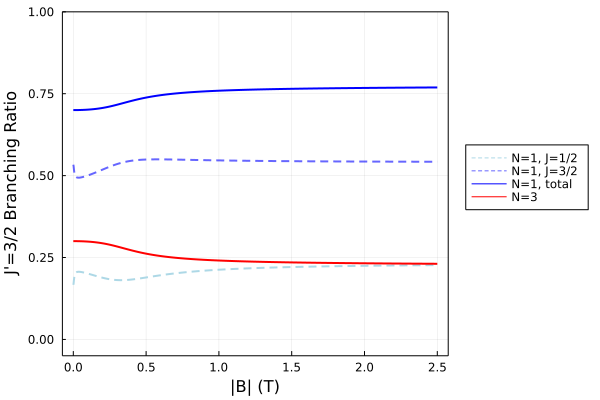

In [19]:
# PLot branching ratios from the J'=3/2 state
outlist_N3 = [] # branching to N=3
outlist_N1 = [] # branching to N=1
outlist_N1J05 = [] # branching to N=1, J=1/2 component
outlist_N1J15 = [] # branching to N=1, J=3/2 component

for bv in 1:length(Blist)
    BRs=branchingratios(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict)
    totalBR = sum(BRs[:,ApJ15])
    push!(outlist_N1, sum(BRs[XN1, ApJ15])/totalBR)
    push!(outlist_N3, sum(BRs[XN3, ApJ15])/totalBR)
    push!(outlist_N1J05, sum(BRs[XN1J05, ApJ15])/totalBR)
    push!(outlist_N1J15, sum(BRs[XN1J15, ApJ15])/totalBR)
end
plot(Blist/1e4, outlist_N1J05, lw=2, color=:lightblue, linealpha=1, linestyle=:dash, label="N=1, J=1/2")
plot!(Blist/1e4, outlist_N1J15, lw=2, color=:blue, linealpha=0.6, linestyle=:dash, label="N=1, J=3/2")
plot!(Blist/1e4, outlist_N1, lw=2, color=:blue,  label="N=1, total")
plot!(Blist/1e4, outlist_N3, lw=2, color=:red, label="N=3")
plot!(legend=:outerright, frame=:box)

xlabel!("|B| (T)")
ylabel!("J'=3/2 Branching Ratio")
ylims!(-0.05,1)

Now look at spin flip probabilities. For example, consider driving all WFS states at ~2 T to each of the 3 components of the excited Zeeman manifold and look at the probability that decays go into the SFS ground states. Then, look at driving all SFS states at ~0.1 T to each of the 3 excited state components and look at the probability that decays go to the WFS ground state. 

Repeat both of these as a function of laser polarization. 

In [20]:
# Go back to conditioning states based on WFS/SFS nature.
XindsDict = subspaceinds(eigsysX, conditionsX_WFSSFS)
AindsDict = subspaceinds(eigsysA, conditionsA_WFSSFS)
;

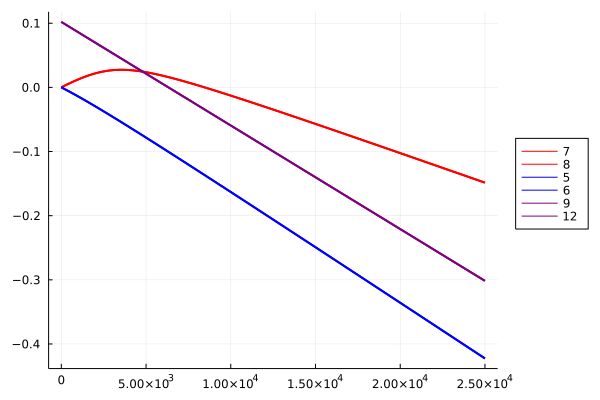

In [21]:
# GROUND STATES
N1SFSinds = XindsDict[1,"SFS"]
N1WFSinds = XindsDict[1,"WFS"]
N3SFSinds = XindsDict[3,"SFS"]
N3WFSinds = XindsDict[3,"WFS"]

# EXCITED STATES
J05plusWFSinds = AindsDict[1/2,+1,"WFS"]
J05plusSFSinds = AindsDict[1/2,+1,"SFS"]
J05inds = reduce(vcat, [J05plusWFSinds, J05plusSFSinds])
J15plusSFSinds = AindsDict[3/2,+1,"SFS"] # Note:  only picks out the M=3/2 component due to where we checked the energy condition on WFS/SFS def'n.
plot(legend=:right)
for i in J05plusWFSinds
    plot!(Blist, eigsysA[i,:].E .- mean(eigsysA[J05inds,1].E), color=:red, legend=false, lw=2, label="$(i)")
end
for i in J05plusSFSinds
    plot!(Blist, eigsysA[i,:].E .- mean(eigsysA[J05inds,1].E), color=:blue, legend=false, lw=2, label="$(i)")
end
for i in J15plusSFSinds
    plot!(Blist, eigsysA[i,:].E .- mean(eigsysA[J05inds,1].E), color=:purple, legend=false, lw=2, label="$(i)")
end
plot!(legend=:outerright)


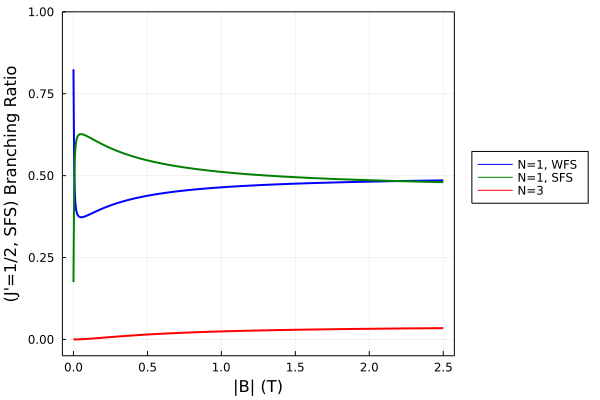

In [22]:
# then, compute branching ratios for J' states to the WFS manifold and to the SFS manifold.
outlist_N1WFS = [] # branching to N=1 WFS manifolds
outlist_N1SFS = [] # branching to N=1 SFS manifolds
outlist_N3WFS = [] # branching to N=3 WFS manifolds
outlist_N3SFS = [] # branching to N=3 SFS manifolds
# excitedinds = reduce(vcat,[J05plusSFSinds,J05plusWFSinds])
excitedinds = J05plusSFSinds
for bv in 1:length(Blist)
    BRs=branchingratios(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict)
    totaldecay = sum(BRs[:,excitedinds])
    push!(outlist_N1WFS, sum(BRs[N1WFSinds,excitedinds])/totaldecay)
    push!(outlist_N1SFS, sum(BRs[N1SFSinds,excitedinds])/totaldecay)
    push!(outlist_N3WFS, sum(BRs[N3WFSinds,excitedinds])/totaldecay)
    push!(outlist_N3SFS, sum(BRs[N3SFSinds,excitedinds])/totaldecay)
end

plot(Blist/1e4, outlist_N1WFS, lw=2, color=:blue, label="N=1, WFS")
plot!(Blist/1e4, outlist_N1SFS, lw=2, color=:green, label="N=1, SFS")
plot!(Blist/1e4, outlist_N3WFS+outlist_N3SFS, lw=2, color=:red, label="N=3", legend=:outerright, framestyle=:box)
xlabel!("|B| (T)")
if excitedinds == J05plusSFSinds
    ylab = "(J'=1/2, SFS) Branching Ratio"
elseif excitedinds == J05plusWFSinds
    ylab = "(J'=1/2, WFS) Branching Ratio"
elseif excitedinds == J15plusSFSinds
    ylab = "(J'=3/2, SFS) Branching Ratio"
else 
    ylab = "Branching Ratio"
end
ylabel!(ylab)
ylims!(-0.05,1)


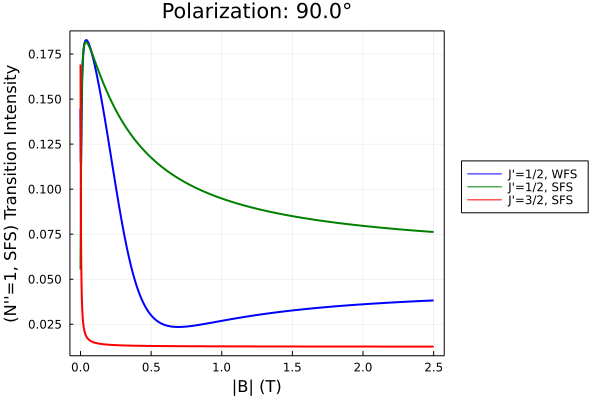

In [23]:
# also, compute transition intensiities from the WFS and SFS manifold up to each of the J' states. 
# then, compute branching ratios for J' states to the WFS manifold and to the SFS manifold.
outlist_J05WFS = [] # branching to N=1 WFS manifolds
outlist_J05SFS = [] # branching to N=1 SFS manifolds
outlist_J15SFS = [] # branching to N=3 WFS manifolds
groundinds = N1SFSinds
polangle = pi/2
for bv in 1:length(Blist)
    TIs=transitionintensities(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict, polangle)
    totalintensity = sum(TIs[groundinds, :])
    push!(outlist_J05WFS, sum(TIs[groundinds, J05plusWFSinds])/totalintensity)
    push!(outlist_J05SFS, sum(TIs[groundinds, J05plusSFSinds])/totalintensity)
    push!(outlist_J15SFS, sum(TIs[groundinds, J15plusSFSinds])/totalintensity)
end

plot(Blist/1e4, outlist_J05WFS, lw=2, color=:blue, label="J'=1/2, WFS")
plot!(Blist/1e4, outlist_J05SFS, lw=2, color=:green, label="J'=1/2, SFS")
plot!(Blist/1e4, outlist_J15SFS, lw=2, color=:red, label="J'=3/2, SFS", legend=:outerright, framestyle=:box)
xlabel!("|B| (T)")
if groundinds == N1SFSinds
    ylab = "(N''=1, SFS) Transition Intensity"
elseif groundinds == N1WFSinds
    ylab = "(N''=1, WFS) Transition Intensity"
else 
    ylab = "Transition Intensity"
end
ylabel!(ylab)
plot!(title="Polarization: $(round(polangle*180/pi,digits=2))°")
# ylims!(-0.05,1)

Try varying the polarization angle at fixed B-field.

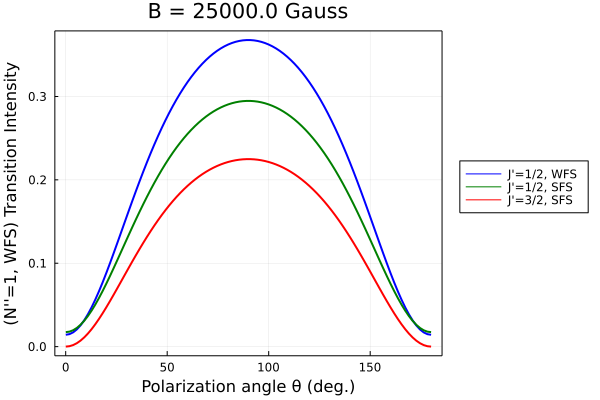

In [24]:
# also, compute transition intensiities from the WFS and SFS manifold up to each of the J' states. 
# then, compute branching ratios for J' states to the WFS manifold and to the SFS manifold.
outlist_J05WFS = [] # branching to N=1 WFS manifolds
outlist_J05SFS = [] # branching to N=1 SFS manifolds
outlist_J15SFS = [] # branching to N=3 WFS manifolds
groundinds = N1WFSinds
bv=1250 # pick B-field index to sit at.
angle_list = range(0.001,stop=pi, length=100)
for polangle in angle_list
    TIs=transitionintensities(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict, polangle)
    totalintensity = sum(TIs[groundinds, :])
    push!(outlist_J05WFS, sum(TIs[groundinds, J05plusWFSinds])/totalintensity)
    push!(outlist_J05SFS, sum(TIs[groundinds, J05plusSFSinds])/totalintensity)
    push!(outlist_J15SFS, sum(TIs[groundinds, J15plusSFSinds])/totalintensity)
end

plot(angle_list*180/pi, outlist_J05WFS, lw=2, color=:blue, label="J'=1/2, WFS")
plot!(angle_list*180/pi, outlist_J05SFS, lw=2, color=:green, label="J'=1/2, SFS")
plot!(angle_list*180/pi, outlist_J15SFS, lw=2, color=:red, label="J'=3/2, SFS", legend=:outerright, framestyle=:box)
xlabel!("Polarization angle θ (deg.)")
if groundinds == N1SFSinds
    ylab = "(N''=1, SFS) Transition Intensity"
elseif groundinds == N1WFSinds
    ylab = "(N''=1, WFS) Transition Intensity"
else 
    ylab = "Transition Intensity"
end
ylabel!(ylab)
plot!(title="B = $(round(Blist[bv],digits=2)) Gauss")
# ylims!(-0.05,1)

In [64]:
bv = 1250
println("B = ", round(Blist[bv],digits=2)," G")
polangle = pi/3
TIs=transitionintensities(eigsysX_a[:,bv], eigsysA[:,bv],TDMDict, polangle)
round.(TIs[reduce(vcat,[N3SFSinds,N3WFSinds]), J05plusSFSinds],digits=3)

B = 25000.0 G


28×2 Matrix{Float64}:
 0.0    0.0
 0.0    0.0
 0.0    0.0
 0.0    0.002
 0.0    0.002
 0.0    0.0
 0.0    0.0
 0.0    0.0
 0.0    0.0
 0.002  0.0
 0.002  0.0
 0.007  0.0
 0.0    0.007
 ⋮      
 0.0    0.0
 0.0    0.003
 0.0    0.001
 0.001  0.0
 0.003  0.0
 0.0    0.0
 0.0    0.0
 0.0    0.0
 0.003  0.0
 0.0    0.003
 0.0    0.0
 0.0    0.0